In [1]:
import json
import gdal
import fiona
import pandas as pd
import geopandas as gpd
import requests
import geopy
import statsmodels

# On windows, some of these libraries cannot be installed right away with pip. 
# Especially gdal and fiona. 
# if you have problems try to use the windows binaries from 
# https://www.lfd.uci.edu/~gohlke/pythonlibs/

ModuleNotFoundError: No module named 'gdal'

Web Api Tutorial.

FAQ: 
1.  What is an API? 
   
    An API (Application Programming Interface) broadly speaking, is a collection of 
    functions that  usually other programs use to interact with your program.
    As such indented users, normally are shielded from *implementation* of the 
    particulars of the code are just exposed to what is important. 
1. What is a Web API.
    
    Similar in nature, a web api, is a collection of *endpoints* that users can contact to initiate a remote procedure. 
    Usually that remote procedure returns a kind of result, typically in a form of a string.
    
    For 90% of the cases, that string contains the information that we are interested about and 
    and is structured that could be parsed as JSON. e.g. :
    
    ```text
    '{  
       "id" : 1,   
       "data": {"name": "Nikos", "age": 35, "gender": "male", "height": 178}       
    }'
    ```
   
   When that string is parsable as JSON, it's called *json string*
1. What is a JSON

    JSON are initials, meaning  **J**ava**S**cript **O**bject **N**otation. 
    
    It is a lightweight data structure format, and primerly aimed to be used with JavaScript, 
    the main language web browesers use. 
    
    Python has it's own json parsing library to parse and create json strings. 
    It's parsing the json's to a python dictionary. For example for the above json string:    

In [2]:
import json
json_string = '{ "id" : 1, "data": {"name": "Nikos", "age": 35, "gender": "male", "height": 178}}'
d = json.loads(json_string)
data = d['data']
for key,value in data.items():
    # I use the *f expresions* to interpolate the variables in the string Templates. 
    print(f"Key: {key.upper()} has value: {value}")

Key: NAME has value: Nikos
Key: AGE has value: 35
Key: GENDER has value: male
Key: HEIGHT has value: 178


To communicate with a remote server, theoretically you don't need anything as Python comes with a complete set of modules that can do that.

Practically, as it is aimed mostly for programmers, you would be using a widely popular python package
called '[Requests](https://requests.readthedocs.io/en/master/)'  

A 'higher' level python package that helps to send HTTP/1.1 requests. 
It's build around pythons build-in 'lower' level web libraries. 


 ```bash
pip install requests
```

After it's installed, making web requests, it's much more straightforward:

```python
# Fetching Chuck Norris Jokes from the Internet Chuck Noris Database.
# http://www.icndb.com/api/

import requests
# Create a Request object from that URL
r = requests.get('http://api.icndb.com/jokes/random?limitTo=[nerdy]')
# Parse the data to a dictionary with the .json() function available
data = r.json()
print('{joke}'.format(joke=data['value']['joke']))
# Chuck Norris types with one finger. He points it at the keyboard and the keyboard does the rest.

```

In [3]:
# Example: 
# Get some information from an end point: 

import requests
import pprint #  pretty print

res = requests.get('http://api.icndb.com/jokes/random')

print(res.text)
print(type(res.text))
print()
d = res.json()  # parse the response to a dictionary. 
print(type(d))
pprint.pprint(d)

# if you want to access somethign inside a dictionary, you can traverse to using it's key:
value = d['value']
joke = value['joke']
print(joke)

{ "type": "success", "value": { "id": 171, "joke": "Chuck Norris can set ants on fire with a magnifying glass. At night.", "categories": [] } }
<class 'str'>

<class 'dict'>
{'type': 'success',
 'value': {'categories': [],
           'id': 171,
           'joke': 'Chuck Norris can set ants on fire with a magnifying glass. '
                   'At night.'}}
Chuck Norris can set ants on fire with a magnifying glass. At night.


A rest api is dynamic in nature.
 
That means that the server can identify parameters 
that the client (you, or your program) is sending to him as part of your request. 

The server then can act on these parameters.

Usually the provider, provide some kind of documentation, 
which they have catalogued the name of the parameters, their types and their meaning. 


In [4]:
# Parameter Example
# Documentation about this API: 
# http://www.icndb.com/api/

import requests
# that API also supports returning multiple jokes at once. 
# .../jokes/random/<number_of_jokes>

r = requests.get('http://api.icndb.com/jokes/random/4')
data = r.json()

idx = 1
for joke_entry in data['value']: 
    print('{idx}: {joke}'.format(idx=idx,joke=joke_entry['joke']))
    idx += 1


1: Chuck Norris lost his virginity before his dad did.
2: Chuck Norris can do a roundhouse kick faster than the speed of light. This means that if you turn on a light switch, you will be dead before the lightbulb turns on.
3: Chuck Norris never wet his bed as a child. The bed wet itself out of fear.
4: Chuck Norris doesn't use a computer because a computer does everything slower than Chuck Norris.


In [5]:
# Also he also declares that we can limit the jokes to a certain category:
r = requests.get('http://api.icndb.com/jokes/random/4?limitTo=[nerdy]')
data = r.json()

# enumerate is a 'build-in' python function to help you, 
# instead of writing the (idx =1 ... idx = idx + 1) pattern
for idx, joke_entry in enumerate(data['value'],1): 
    print('{idx}: {joke}'.format(idx=idx,joke=joke_entry['joke']))


1: Chuck Norris can delete the Recycling Bin.
2: All browsers support the hex definitions #chuck and #norris for the colors black and blue.
3: Chuck Norris doesn't need a keyboard he tells the computer to write something and it does.
4: To Chuck Norris, everything contains a vulnerability.


Obviously, there is a lot of repetition, so when that is happening it is always 
it is always a good idea not to repeat yourself, by generalising. 
In this case, we can construct a function does all the  steps:


In [6]:
import requests

def get_jokes(how_many=2, nerdy_only=True, verbose=False):
    """ Get a number of jokes from the Internet Chuck Norris Database. 
    Returns a list of Dictionaries. 
    Will raise an exception if if the server cannot complete our request """
    request_url = 'http://api.icndb.com/jokes/random/'
    if int(how_many)>0:
        request_url += str(how_many)
    if nerdy_only:
        request_url += '?limitTo=[nerdy]'
    if verbose:
        print(request_url)
    r = requests.get(request_url)
    r.raise_for_status() 
    
    return r.json()['value']

In [7]:
get_jokes(how_many=2, nerdy_only=True, verbose=True)

http://api.icndb.com/jokes/random/2?limitTo=[nerdy]


[{'id': 479,
  'joke': 'Chuck Norris does not need to know about class factory pattern. He can instantiate interfaces.',
  'categories': ['nerdy']},
 {'id': 494,
  'joke': 'Chuck Norris breaks RSA 128-bit encrypted codes in milliseconds.',
  'categories': ['nerdy']}]

In [8]:
jokes = get_jokes(5,nerdy_only=False)
for idx, joke in enumerate(jokes,1):
    print(idx, joke['joke'], sep='. ')

1. Chuck Norris's first program was kill -9.
2. When Chuck Norris throws exceptions, it's across the room.
3. Chuck Norris once sued Burger King after they refused to put razor wire in his Whopper Jr, insisting that that actually is &quot;his&quot; way.
4. The grass is always greener on the other side, unless Chuck Norris has been there. In that case the grass is most likely soaked in blood and tears.
5. Chuck Norris uses tabasco sauce instead of visine.


### Airbnb Data. 


UBDC is collecting public data from airbnb, regarding the listings, their locations and relevant information. 

Part of that service is to create a web API, where reserchers could connect and request data for their analyses. 

The work is still yet in-progress, with many things still planned but not implemented it. 

#### TimeSeries

In [9]:
# Make subsequent  any plots a little bigger
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["figure.dpi"] = 125

Airbnb does not give direct information about how amny bookings are made through her platform.  
Interestingly enough, we can see the comments per listings when we navigate in their website.

eg: For the this listing: [3740403](https://www.airbnb.co.uk/rooms/3740403), if we navigate at it page, 
we can see it has more than 700 reviews. These reviews could serve as an indirect way to calculate a sense of 
what is happening.

So far, we have scollected all the comments from the City of Edinburgh for all the listings. And the first API 
end point that we can explore serves that as a timeseries [http://130.209.67.41:8000/api/reports/comments_ts]
 

In [10]:
import pandas
import requests
import pprint
# we can modify the request to to ask the api to group the comments in this AOI per weeks, months or days. 
# I've disabled a lower interval, as it was too calculative intensive ...for now
comments_ts_endoing = 'http://130.209.67.121/api/reports/comments_ts?aoi_pk=1&interval=weeks'
res = requests.get(comments_ts_endoing)
data = res.json()[0]['data']

for idx,(datetime_string,number_of_comments) in enumerate(data,1):
    if idx > 10:
        break
    print(idx,datetime_string,number_of_comments)

1 2010-08-16T00:00:00 1
2 2010-08-23T00:00:00 1
3 2010-08-30T00:00:00 1
4 2010-09-06T00:00:00 1
5 2010-09-13T00:00:00 2
6 2010-09-20T00:00:00 1
7 2010-09-27T00:00:00 1
8 2010-10-04T00:00:00 0
9 2010-10-11T00:00:00 0
10 2010-10-18T00:00:00 1


In [11]:
# Let's plot the data, for an initial view

# firstly we need to 'parse' the datetime strings to datetime objects that they are used to represent time point
df = pandas.DataFrame(data,columns=['datetime','number_of_comments'])
df['datetime'] = pandas.to_datetime(df['datetime'])

# then set the datetime column as index
df=df.set_index('datetime')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 497 entries, 2010-08-16 to 2020-02-17
Data columns (total 1 columns):
number_of_comments    497 non-null int64
dtypes: int64(1)
memory usage: 7.8 KB


,number_of_comments
datetime,
2010-08-16,1
2010-08-23,1
2010-08-30,1
2010-09-06,1
2010-09-13,2


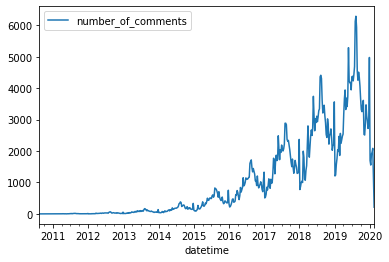

In [12]:
# and now we can plot using padnas .plot convience function
df.plot()

## Hmm, the data seem to have a seasonal aspect: At summer time the commments are increasing, while at winter time they seem to be lower. 

This effect is called seasonality, and can be seen in many datasets that represent event that are sensitive to periodic effects. 

Like airplane tickets or hotel bookings. During holiday periods you would expect higher sales, and during offseasons less sales.

In the recent years, Timeseries analysis libraries have been developed for python that make the decomposition (=decomposing a time series to its elements: trent, seasonality, and noise) of Timeseries data much easier of what it used to be, and a much valuable tool for data exploration.

Be careful though, although it is seems easy TS analysis is a beast in itself.


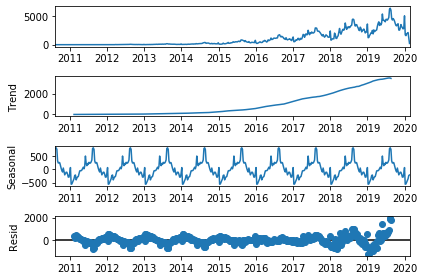

In [13]:
import statsmodels.api as sm
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
# decompose the timeseries to its elements using a naive model:
decomposition = sm.tsa.seasonal_decompose(df, model='additive')

# and plot them to see the elements sepereratly. 
 
fig = decomposition.plot()

Remember the timeseries of the observed values are f(t) = Trend(t) + Seasonality(t) + Error(t)
The rule of thumb to see if a model is performing, is the errors chart: It should be as close to zero as possible.

In this case we can see the the residuals as orbiting 0 until late 2018. After that they start to get move away from the zero line, which means that from that date onwards our model is not very good explaining the observations and maybe needs further refining. 

But it's a good start !

#### Geocoding

Usually rest api serve data from their databases. And usually they give ways for clients to queury their data according to their needs. 

In the same airbnb context, the api can understand a location, and return the listings that are found within the specified range around it. 

Conceptually it can answer to this question:

> Which listings are within X metres around the Y location?


In [23]:
from pathlib import Path
from io import BytesIO
import requests
import geopandas

listings_endpoint = 'http://130.209.67.121/api/data/listings'
DEFAULT_RADIUS = 500

def random_point_param(radius=DEFAULT_RADIUS)->dict:
    """ Returns a parameter dictionary to be used in a request to ubdc listings endpoint"""
    centroids_gdf = geopandas.read_file('centroids.json')
    random_entry = centroids_gdf.sample().to_dict('r')[0]
    random_entry.pop('geometry')
    # rename keys to be more aligned to ubdc rest api
    random_entry['lon'] = random_entry.pop('xcoord')
    random_entry['lat'] = random_entry.pop('ycoord')
    random_entry['radius'] = radius
    return random_entry

params = random_point_param()

######################################################

res = requests.get(listings_endpoint,params=params)
res.raise_for_status()


###  constct a dataframe from the result
# 
# we know that the response of our end point is a valid geojson, a file well known to geopandas.
# 'normally' because the way geopandas operates; we would have saved the result to a file and then read it afterwards
# but instead we are taking a shortcut. 
# We are saving it to memory using the BytesIO object from io library, 
# which returns an object that implements the interface geopandas expects.
# the .contents method returns the response form the server in bytes

listings_df = geopandas.read_file(BytesIO(res.content))

# Sometimes, when the data are too many, they come back in in batches -i.e. 25 at the time. So if your query 
# would return 250, you would get 10 pages containing 25 results in each page. 
# 
# The following code is working in that assumption:
# 
# If the key 'next' in the dictionaric represantation has a value, that means there is a 'next' page.
# get the contents, and append them to the original dataframe

while res.json()['next']:

    res = requests.get(res.json()['next'])
    
    res.raise_for_status()
    
    print(res.url)
    
    this_page = geopandas.read_file(BytesIO(res.content))
    
    listings_df.append(this_page)
    

http://130.209.67.121/api/data/listings?lat=55.94227871136693&lon=-3.223114013671875&page=2&radius=500
http://130.209.67.121/api/data/listings?lat=55.94227871136693&lon=-3.223114013671875&page=3&radius=500
http://130.209.67.121/api/data/listings?lat=55.94227871136693&lon=-3.223114013671875&page=4&radius=500
http://130.209.67.121/api/data/listings?lat=55.94227871136693&lon=-3.223114013671875&page=5&radius=500


In [24]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# here we create a geolocator, using Nominatim; Operated by OpenStreetsMaps. 
# Other providers exist, like google, Bing, and more, but typically they require an API Key to identify yourself.
# a list of supported geocoders along how your can use them can be found here:
# https://geopy.readthedocs.io/en/stable/#module-geopy.geocoders
geolocator = Nominatim(user_agent="ubdc_lab")

# when talking to a public api, ususally to provide fair service to all they employ Quality of Service Tactics,
# which usually limiting the rate of requests cna on ask. If you start requesting more from what they allow, they 
# will eventually 'block' any requests comming from your API for a set amount of time. 
# if you want to learn more about it here: https://www.nginx.com/blog/rate-limiting-nginx/

# The RateLimiter object bellow is designed for such occasions: normally python would run the request operation 
# as fast as possible, which could block our IP by their automatic guardians. To avoid that, the RateLimiter, 'slows' 
# the rate of request to a prespecified time: 


reverse_geocode = RateLimiter(geolocator.reverse,min_delay_seconds=1)



In [25]:
import ssl
import geopy.geocoders
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE
geopy.geocoders.options.default_ssl_context = ctx

In [26]:
# Remember; the more the entries you have, more time it will take to finish.  
# so in the intrest of saving time now, lets operate only in a sample of 25 listings.

# pick 25 rows random rows from the dataframe
if len(listings_df) >= 25:
    listings_df_sample = listings_df.sample(25)
else:
    listings_df_sample = listings_df.copy()


# Apply the reverse geocode, parametrasising form the geometry object. It will create a Location object. 

# one can access the longitude and latitude information frmo the .y and .x functions  
listings_df_sample['location'] = listings_df_sample['geometry'].apply(lambda geom_object: reverse_geocode(f'{geom_object.y} {geom_object.x}'))

# Location objects give the address comportment using the .address method.   
listings_df_sample['address'] = listings_df_sample['location'].apply(lambda entry: entry.address)

In [27]:
listings_df_sample.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25 entries, 11 to 19
Data columns (total 13 columns):
listing_id            25 non-null int64
name                  25 non-null object
timestamp             25 non-null object
number_of_comments    25 non-null int64
minimum_nights        25 non-null int64
average_rating        25 non-null float64
airbnb_listing_url    25 non-null object
listing_updated       25 non-null object
calendar_updated      25 non-null object
comment_update        25 non-null object
geometry              25 non-null geometry
location              25 non-null object
address               25 non-null object
dtypes: float64(1), geometry(1), int64(3), object(8)
memory usage: 2.7+ KB


In [28]:
listings_df_sample.head()

,listing_id,name,timestamp,number_of_comments,minimum_nights,average_rating,airbnb_listing_url,listing_updated,calendar_updated,comment_update,geometry,location,address
11,732018,Apt1- Welcoming city home with pool,2020-01-17T18:44:32,109,2,4.69,https://www.airbnb.co.uk/rooms/732018,2020-02-24T20:18:36,2020-02-25T19:24:12,2020-02-18T06:17:41,POINT (-3.21890 55.94196),"(43, Caledonian Crescent, Ardmillan, Dalry, Ed...","43, Caledonian Crescent, Ardmillan, Dalry, Edi..."
6,10762221,Modern 3 Bed Flat near Haymarket - FREE PARKING,2020-01-17T18:44:26,172,2,4.82,https://www.airbnb.co.uk/rooms/10762221,2020-02-24T20:16:18,2020-02-25T19:21:54,2020-02-18T06:01:18,POINT (-3.22562 55.94285),"(3, Northcote Street, Dalry, Edinburgh, City o...","3, Northcote Street, Dalry, Edinburgh, City of..."
15,34245374,Double room in ground floor apartment in Hayma...,2020-01-17T18:44:56,4,2,5.00,https://www.airbnb.co.uk/rooms/34245374,2020-02-24T20:23:12,2020-02-25T19:28:51,2020-02-13T21:43:59,POINT (-3.22603 55.94293),"(1, Northcote Street, Dalry, Edinburgh, City o...","1, Northcote Street, Dalry, Edinburgh, City of..."
18,37858799,Superb main door one bedroom flat,2020-01-17T18:44:56,21,2,4.89,https://www.airbnb.co.uk/rooms/37858799,2020-02-24T20:23:29,2020-02-25T19:29:06,2020-02-13T21:55:42,POINT (-3.22489 55.94070),"(2, Murieston Crescent Lane, Murieston, Dalry,...","2, Murieston Crescent Lane, Murieston, Dalry, ..."
24,18754599,Central 1 BR Apartment With Links To Airport,2020-01-17T18:44:56,24,2,4.30,https://www.airbnb.co.uk/rooms/18754599,2020-02-24T20:23:54,2020-02-25T19:29:33,2020-02-13T21:56:16,POINT (-3.22551 55.94227),"(29, Duff Street, Dalry, Edinburgh, City of Ed...","29, Duff Street, Dalry, Edinburgh, City of Edi..."


##### Saving the Results

If we wish, we can save the results now in many different formats. As our dataframe has spatial information, it is a good idea to save it in a format that is popular with GIS softwares.

For QGIS, saving it as geojson is a good choise as it is one file and you can drag-and-drop it in it.

Downsize of geojson formats is that it can has troubles saving binary information as the driver doesn't know how to serialise it (=textual representation) to save it. 

In [31]:
# drop the location column
# to_save_df = listings_df.drop(columns='location',inplace=False)
to_save_df = listings_df
# and save it using the geoJSON driver. 
# geopandas is using Fiona library as a proxy to read and write geospatial files, so as it extends it can read and write 
# whatever fiona can. 
# you can find a lists of the drivers here: https://github.com/Toblerity/Fiona/blob/master/fiona/drvsupport.py

to_save_df.to_file("listings.json", driver='GeoJSON')